In [1]:
!pip install colossalai

In [2]:
import os
from pathlib import Path
import math
import colossalai
import torch
import torch.nn as nn
import torch.nn.functional as F
from colossalai.core import global_context as gpc
from colossalai.logging import get_dist_logger
from colossalai.nn import CosineAnnealingLR
from colossalai.nn.metric import Accuracy
from colossalai.trainer import Trainer, hooks
from colossalai.utils import MultiTimer, get_dataloader
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
torch.__version__

'1.10.0+cu111'

In [4]:
colossalai.__version__

'0.0.1'

In [5]:
torch.cuda.is_available()

True

In [6]:


class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits


config = {'BATCH_SIZE':128,'NUM_EPOCHS':30}

colossalai.launch(config=config,rank=0,world_size=1,host='127.0.0.1',port=1234)

logger = get_dist_logger()



[04/01/22 12:55:53] INFO     colossalai -                             ]8;id=901619;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py\distributed_c10d.py]8;;\:]8;id=740249;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py#217\217]8;;\
                             torch.distributed.distributed_c10d -                            
                             2022-04-01 12:55:53,679 INFO: Added key:                        
                             store_based_barrier_key:1 to store for                          
                             rank: 0                                                         

                    INFO     colossalai -                             ]8;id=1077;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py\distributed_c10d.py]8;;\:]8;id=21625;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py#252\252]8;;\
                             torch.distributed.distributed_c10d -                            
                             2022-04-01 12:55:53,691 INFO: Rank 0:                           
                             Completed store-based barrier for                               
                             key:store_based_barrier_key:1 with 1                            
                             nodes.                                                          

                    INFO     colossalai -                             ]8;id=494942;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py\distributed_c10d.py]8;;\:]8;id=418990;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py#217\217]8;;\
                             torch.distributed.distributed_c10d -                            
                             2022-04-01 12:55:53,699 INFO: Added key:                        
                             store_based_barrier_key:2 to store for                          
                             rank: 0                                                         

                    INFO     colossalai -                             ]8;id=788839;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py\distributed_c10d.py]8;;\:]8;id=799498;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py#252\252]8;;\
                             torch.distributed.distributed_c10d -                            
                             2022-04-01 12:55:53,714 INFO: Rank 0:                           
                             Completed store-based barrier for                               
                             key:store_based_barrier_key:2 with 1                            
                             nodes.                                                          

                    INFO     colossalai -                             ]8;id=331844;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py\distributed_c10d.py]8;;\:]8;id=808573;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py#217\217]8;;\
                             torch.distributed.distributed_c10d -                            
                             2022-04-01 12:55:53,720 INFO: Added key:                        
                             store_based_barrier_key:3 to store for                          
                             rank: 0                                                         

                    INFO     colossalai -                             ]8;id=824678;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py\distributed_c10d.py]8;;\:]8;id=647146;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py#252\252]8;;\
                             torch.distributed.distributed_c10d -                            
                             2022-04-01 12:55:53,727 INFO: Rank 0:                           
                             Completed store-based barrier for                               
                             key:store_based_barrier_key:3 with 1                            
                             nodes.                                                          

                    INFO     colossalai -                             ]8;id=239484;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py\distributed_c10d.py]8;;\:]8;id=702296;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py#217\217]8;;\
                             torch.distributed.distributed_c10d -                            
                             2022-04-01 12:55:53,734 INFO: Added key:                        
                             store_based_barrier_key:4 to store for                          
                             rank: 0                                                         

                    INFO     colossalai -                             ]8;id=108187;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py\distributed_c10d.py]8;;\:]8;id=958681;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py#252\252]8;;\
                             torch.distributed.distributed_c10d -                            
                             2022-04-01 12:55:53,741 INFO: Rank 0:                           
                             Completed store-based barrier for                               
                             key:store_based_barrier_key:4 with 1                            
                             nodes.                                                          

                    INFO     colossalai - colossalai - 2022-04-01 12:55:53,749  ]8;id=344013;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=768554;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: process rank 0 is bound to device 0                       

                    INFO     colossalai - colossalai - 2022-04-01 12:55:53,755  ]8;id=835769;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=20063;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: initialized seed on rank 0, numpy: 1024,                  
                             python random: 1024, ParallelMode.DATA: 1024,                   
                             ParallelMode.TENSOR: 1024,the default parallel                  
                             seed is ParallelMode.DATA.                                      

                    INFO     colossalai - colossalai - 2022-04-01 12:55:53,763  ]8;id=506985;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=408344;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO: Distributed environment is initialized, data              
                             parallel size: 1, pipeline parallel size: 1,                    
                             tensor parallel size: 1                                         

In [7]:

# build 

model = LeNet5(n_classes=10)

# build dataloaders
train_dataset = MNIST(
    root=Path('./tmp/'),
    download=True,
    transform = transforms.Compose([transforms.Resize((32, 32)),
                              transforms.ToTensor()])
)

test_dataset = MNIST(
    root=Path('./tmp/'),
    train=False,
    transform = transforms.Compose([transforms.Resize((32, 32)),
                              transforms.ToTensor()])
)

train_dataloader = get_dataloader(dataset=train_dataset,
                                  shuffle=True,
                                  batch_size=gpc.config.BATCH_SIZE,
                                  num_workers=1,
                                  pin_memory=True,
                                  )

test_dataloader = get_dataloader(dataset=test_dataset,
                                  add_sampler=False,
                                  batch_size=gpc.config.BATCH_SIZE,
                                  num_workers=1,
                                  pin_memory=True,
                                  )

# build criterion
criterion = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

#exponentially increase learning rate from low to high
def lrs(batch):
    low = math.log2(1e-5)
    high = math.log2(10)
    return 2**(low+(high-low)*batch/len(train_dataloader)/gpc.config.NUM_EPOCHS)




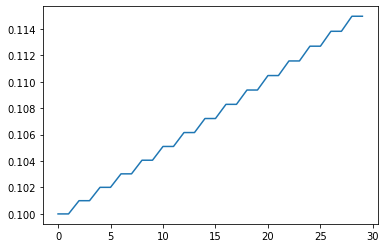

In [8]:
# lr_scheduler, lambda or onecycle
#lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lrs)
#lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=2*(len(train_dataloader)), epochs=30)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=1.01)

lrs = []
for i in range(30):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    lr_scheduler.step()

plt.plot(range(30),lrs)

In [9]:

engine, train_dataloader, test_dataloader, _ = colossalai.initialize(model,
                                        optimizer,
                                        criterion,
                                        train_dataloader,
                                        test_dataloader,
                                        )
# build a timer to measure time
timer = MultiTimer()

# create a trainer object
trainer = Trainer(
    engine=engine,
    timer=timer,
    logger=logger
)

# define the hooks to attach to the trainer
hook_list = [
    hooks.LossHook(),
    hooks.LRSchedulerHook(lr_scheduler=lr_scheduler, by_epoch=False),
    # hooks.AccuracyHook(accuracy_func=Accuracy()),
    hooks.LogMetricByEpochHook(logger),
    hooks.LogMemoryByEpochHook(logger),
    hooks.LogTimingByEpochHook(timer, logger),

    # you can uncomment these lines if you wish to use them
    hooks.TensorboardHook(log_dir='./tb_logs', ranks=[0]),
    # hooks.SaveCheckpointHook(checkpoint_dir='./ckpt')
]

# start training
trainer.fit(
    train_dataloader=train_dataloader,
    epochs=gpc.config.NUM_EPOCHS,
    test_dataloader=test_dataloader,
    test_interval=1,
    hooks=hook_list,
    display_progress=True
)

[04/01/22 12:55:54] INFO     colossalai - colossalai - 2022-04-01 12:55:54,142  ]8;id=338916;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=869699;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO:                                                           
                             ========== Your Config ========                                 
                             {'BATCH_SIZE': 128, 'NUM_EPOCHS': 30}                           
                             ================================                                
                                                                                             

                    INFO     colossalai - colossalai - 2022-04-01 12:55:54,149  ]8;id=831130;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=912715;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO: cuDNN benchmark = True, deterministic =                   
                             False                                                           

[04/01/22 12:55:56] WARNING  colossalai - colossalai - 2022-04-01 12:55:56,946  ]8;id=545030;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=105313;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             WARNING: Initializing an non ZeRO model with                    
                             optimizer class                                                 

                    WARNING  colossalai - colossalai - 2022-04-01 12:55:56,950  ]8;id=466742;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=537792;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             WARNING: No PyTorch DDP or gradient handler is set              
                             up, please make sure you do not need to all-reduce              
                             the gradients after a training step.                            

[04/01/22 12:56:01] INFO     colossalai - colossalai - 2022-04-01 12:56:01,004  ]8;id=383671;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=847219;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO: Using LossHook for training, priority = 0                 

                    INFO     colossalai - colossalai - 2022-04-01 12:56:01,013  ]8;id=756882;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=846255;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO: Using LRSchedulerHook for training, priority              
                             = 1                                                             

                    INFO     colossalai - colossalai - 2022-04-01 12:56:01,029  ]8;id=750747;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=386742;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO: Using LogMetricByEpochHook for training,                  
                             priority = 10                                                   

                    INFO     colossalai - colossalai - 2022-04-01 12:56:01,040  ]8;id=407266;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=832621;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO: Using LogMemoryByEpochHook for training,                  
                             priority = 10                                                   

                    INFO     colossalai - colossalai - 2022-04-01 12:56:01,054  ]8;id=100681;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=745997;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO: Using LogTimingByEpochHook for training,                  
                             priority = 10                                                   

                    INFO     colossalai - colossalai - 2022-04-01 12:56:01,069  ]8;id=781049;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=916139;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO: Using TensorboardHook for training, priority              
                             = 10                                                            

                    INFO     colossalai - colossalai - 2022-04-01 12:56:01,081  ]8;id=146962;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=836397;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO: Lower value means higher priority for                     
                             calling hook function                                           

[04/01/22 12:56:02] INFO     colossalai - colossalai - 2022-04-01 12:56:02,102  ]8;id=408446;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=107259;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: Before-train: GPU: allocated 0.24 MB, max                 
                             allocated 0.24 MB, cached: 2.0 MB, max cached: 2.0              
                             MB                                                              

[Epoch 0 / Train]: 100%|██████████| 469/469 [00:20<00:00, 22.37it/s]


[04/01/22 12:56:23] INFO     colossalai - colossalai - 2022-04-01 12:56:23,265  ]8;id=429527;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=162597;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 0 / Train]: Loss = 21.387 | LR =                   
                             1.1913                                                          

                    INFO     colossalai - colossalai - 2022-04-01 12:56:23,273  ]8;id=457398;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=496973;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 0 / Train]: GPU: allocated 4.94 MB,                
                             max allocated 88.39 MB, cached: 26.0 MB, max                    
                             cached: 108.0 MB                                                

                    INFO     colossalai - colossalai - 2022-04-01 12:56:23,283  ]8;id=467890;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=770472;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 0 / Train]: Train-epoch: last = 20.97              
                             s, mean = 20.97 s | Train-step: last = 0.088701 s,              
                             mean = 0.041171 s | #steps/epoch = 469                          

[Epoch 0 / Test]: 100%|██████████| 79/79 [00:02<00:00, 32.72it/s]


[04/01/22 12:56:25] INFO     colossalai - colossalai - 2022-04-01 12:56:25,799  ]8;id=550437;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=884148;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 0 / Test]: Loss = 39.385                           

                    INFO     colossalai - colossalai - 2022-04-01 12:56:25,810  ]8;id=966525;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=364022;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 0 / Test]: Test-epoch: last = 2.4059               
                             s, mean = 2.4059 s | Test-step: last = 0.024264 s,              
                             mean = 0.027781 s                                               

                    INFO     colossalai - colossalai - 2022-04-01 12:56:25,825  ]8;id=646487;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=947990;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 0 / Test]: GPU: allocated 0.96 MB,                 
                             max allocated 18.05 MB, cached: 24.0 MB, max                    
                             cached: 26.0 MB                                                 

[Epoch 1 / Train]: 100%|██████████| 469/469 [00:16<00:00, 28.77it/s]


[04/01/22 12:56:42] INFO     colossalai - colossalai - 2022-04-01 12:56:42,234  ]8;id=637420;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=92566;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 1 / Train]: Loss = 248.65 | LR =                   
                             12.347                                                          

                    INFO     colossalai - colossalai - 2022-04-01 12:56:42,245  ]8;id=36874;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=87591;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 1 / Train]: GPU: allocated 4.94 MB,                
                             max allocated 22.09 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 12:56:42,255  ]8;id=667345;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=807369;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 1 / Train]: Train-epoch: last =                    
                             16.305 s, mean = 16.305 s | Train-step: last =                  
                             0.013286 s, mean = 0.036367 s | #steps/epoch = 469              

[Epoch 1 / Test]: 100%|██████████| 79/79 [00:02<00:00, 32.84it/s]


[04/01/22 12:56:44] INFO     colossalai - colossalai - 2022-04-01 12:56:44,777  ]8;id=86073;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=107367;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 1 / Test]: Loss = 603.33                           

                    INFO     colossalai - colossalai - 2022-04-01 12:56:44,786  ]8;id=379642;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=722727;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 1 / Test]: Test-epoch: last = 2.4111               
                             s, mean = 2.4111 s | Test-step: last = 0.0033896                
                             s, mean = 0.028296 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 12:56:44,795  ]8;id=350587;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=914387;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 1 / Test]: GPU: allocated 0.96 MB,                 
                             max allocated 6.05 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 2 / Train]: 100%|██████████| 469/469 [00:16<00:00, 28.40it/s]


[04/01/22 12:57:01] INFO     colossalai - colossalai - 2022-04-01 12:57:01,430  ]8;id=3561;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=388801;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 2 / Train]: Loss = 2565.5 | LR =                   
                             126.69                                                          

                    INFO     colossalai - colossalai - 2022-04-01 12:57:01,440  ]8;id=971517;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=315445;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 2 / Train]: GPU: allocated 4.94 MB,                
                             max allocated 22.09 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 12:57:01,451  ]8;id=191330;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=141390;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 2 / Train]: Train-epoch: last =                    
                             16.517 s, mean = 16.517 s | Train-step: last =                  
                             0.018071 s, mean = 0.034794 s | #steps/epoch = 469              

[Epoch 2 / Test]: 100%|██████████| 79/79 [00:02<00:00, 32.54it/s]


[04/01/22 12:57:03] INFO     colossalai - colossalai - 2022-04-01 12:57:03,998  ]8;id=167384;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=959325;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 2 / Test]: Loss = 4212.7                           

[04/01/22 12:57:04] INFO     colossalai - colossalai - 2022-04-01 12:57:04,007  ]8;id=408057;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=299722;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 2 / Test]: Test-epoch: last = 2.429                
                             s, mean = 2.429 s | Test-step: last = 0.00403 s,                
                             mean = 0.028349 s                                               

                    INFO     colossalai - colossalai - 2022-04-01 12:57:04,019  ]8;id=168896;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=907314;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 2 / Test]: GPU: allocated 0.96 MB,                 
                             max allocated 6.05 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 3 / Train]: 100%|██████████| 469/469 [00:16<00:00, 28.29it/s]


[04/01/22 12:57:20] INFO     colossalai - colossalai - 2022-04-01 12:57:20,713  ]8;id=95277;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=240130;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 3 / Train]: Loss = 26013 | LR = 1313               

                    INFO     colossalai - colossalai - 2022-04-01 12:57:20,723  ]8;id=860176;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=610902;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 3 / Train]: GPU: allocated 4.94 MB,                
                             max allocated 22.09 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 12:57:20,733  ]8;id=126868;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=481816;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 3 / Train]: Train-epoch: last =                    
                             16.578 s, mean = 16.578 s | Train-step: last =                  
                             0.019324 s, mean = 0.034024 s | #steps/epoch = 469              

[Epoch 3 / Test]: 100%|██████████| 79/79 [00:02<00:00, 32.23it/s]


[04/01/22 12:57:23] INFO     colossalai - colossalai - 2022-04-01 12:57:23,308  ]8;id=714915;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=949050;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 3 / Test]: Loss = 75996                            

                    INFO     colossalai - colossalai - 2022-04-01 12:57:23,316  ]8;id=588986;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=24862;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 3 / Test]: Test-epoch: last = 2.4521               
                             s, mean = 2.4521 s | Test-step: last = 0.0030093                
                             s, mean = 0.028848 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 12:57:23,328  ]8;id=731619;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=430394;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 3 / Test]: GPU: allocated 0.96 MB,                 
                             max allocated 6.05 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 4 / Train]: 100%|██████████| 469/469 [00:16<00:00, 28.38it/s]


[04/01/22 12:57:39] INFO     colossalai - colossalai - 2022-04-01 12:57:39,956  ]8;id=845059;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=22590;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 4 / Train]: Loss = 2.6267e+05 | LR =               
                             13473                                                           

                    INFO     colossalai - colossalai - 2022-04-01 12:57:39,967  ]8;id=867384;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=22492;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 4 / Train]: GPU: allocated 4.94 MB,                
                             max allocated 22.09 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 12:57:39,973  ]8;id=954487;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=920788;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 4 / Train]: Train-epoch: last =                    
                             16.523 s, mean = 16.523 s | Train-step: last =                  
                             0.013477 s, mean = 0.03357 s | #steps/epoch = 469               

[Epoch 4 / Test]: 100%|██████████| 79/79 [00:02<00:00, 31.88it/s]


[04/01/22 12:57:42] INFO     colossalai - colossalai - 2022-04-01 12:57:42,578  ]8;id=258997;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=788654;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 4 / Test]: Loss = 5.87e+05                         

                    INFO     colossalai - colossalai - 2022-04-01 12:57:42,590  ]8;id=942760;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=868513;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 4 / Test]: Test-epoch: last = 2.4806               
                             s, mean = 2.4806 s | Test-step: last = 0.0015893                
                             s, mean = 0.02891 s                                             

                    INFO     colossalai - colossalai - 2022-04-01 12:57:42,601  ]8;id=162409;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=984032;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 4 / Test]: GPU: allocated 0.96 MB,                 
                             max allocated 6.05 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 5 / Train]: 100%|██████████| 469/469 [00:17<00:00, 26.63it/s]


[04/01/22 12:58:00] INFO     colossalai - colossalai - 2022-04-01 12:58:00,339  ]8;id=349879;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=360737;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 5 / Train]: Loss = 2.6557e+06 | LR =               
                             1.3963e+05                                                      

                    INFO     colossalai - colossalai - 2022-04-01 12:58:00,349  ]8;id=483769;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=918446;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 5 / Train]: GPU: allocated 4.94 MB,                
                             max allocated 22.09 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 12:58:00,365  ]8;id=640060;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=182619;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 5 / Train]: Train-epoch: last =                    
                             17.615 s, mean = 17.615 s | Train-step: last =                  
                             0.018229 s, mean = 0.033582 s | #steps/epoch = 469              

[Epoch 5 / Test]: 100%|██████████| 79/79 [00:02<00:00, 32.68it/s]


[04/01/22 12:58:02] INFO     colossalai - colossalai - 2022-04-01 12:58:02,901  ]8;id=576041;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=725206;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 5 / Test]: Loss = 7.1671e+06                       

                    INFO     colossalai - colossalai - 2022-04-01 12:58:02,910  ]8;id=836666;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=836662;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 5 / Test]: Test-epoch: last = 2.4176               
                             s, mean = 2.4176 s | Test-step: last = 0.0038636                
                             s, mean = 0.028487 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 12:58:02,926  ]8;id=446925;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=63825;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 5 / Test]: GPU: allocated 0.96 MB,                 
                             max allocated 6.05 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 6 / Train]: 100%|██████████| 469/469 [00:16<00:00, 28.95it/s]


[04/01/22 12:58:19] INFO     colossalai - colossalai - 2022-04-01 12:58:19,237  ]8;id=70331;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=977182;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 6 / Train]: Loss = 2.6467e+07 | LR =               
                             1.4328e+06                                                      

                    INFO     colossalai - colossalai - 2022-04-01 12:58:19,249  ]8;id=863207;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=402177;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 6 / Train]: GPU: allocated 4.94 MB,                
                             max allocated 22.09 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 12:58:19,262  ]8;id=905861;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=103165;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 6 / Train]: Train-epoch: last =                    
                             16.199 s, mean = 16.199 s | Train-step: last =                  
                             0.015795 s, mean = 0.033194 s | #steps/epoch = 469              

[Epoch 6 / Test]: 100%|██████████| 79/79 [00:02<00:00, 33.15it/s]


[04/01/22 12:58:21] INFO     colossalai - colossalai - 2022-04-01 12:58:21,753  ]8;id=762359;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=625377;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 6 / Test]: Loss = 7.2475e+07                       

                    INFO     colossalai - colossalai - 2022-04-01 12:58:21,760  ]8;id=407888;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=196577;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 6 / Test]: Test-epoch: last = 2.3863               
                             s, mean = 2.3863 s | Test-step: last = 0.0037103                
                             s, mean = 0.02803 s                                             

                    INFO     colossalai - colossalai - 2022-04-01 12:58:21,777  ]8;id=993663;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=224728;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 6 / Test]: GPU: allocated 0.96 MB,                 
                             max allocated 6.05 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 7 / Train]: 100%|██████████| 469/469 [00:16<00:00, 28.60it/s]


[04/01/22 12:58:38] INFO     colossalai - colossalai - 2022-04-01 12:58:38,305  ]8;id=910994;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=739940;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 7 / Train]: Loss = 2.9332e+08 | LR =               
                             1.485e+07                                                       

                    INFO     colossalai - colossalai - 2022-04-01 12:58:38,320  ]8;id=36037;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=196456;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 7 / Train]: GPU: allocated 4.94 MB,                
                             max allocated 22.09 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 12:58:38,330  ]8;id=647959;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=839321;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 7 / Train]: Train-epoch: last =                    
                             16.402 s, mean = 16.402 s | Train-step: last =                  
                             0.018589 s, mean = 0.032931 s | #steps/epoch = 469              

[Epoch 7 / Test]: 100%|██████████| 79/79 [00:02<00:00, 30.89it/s]


[04/01/22 12:58:41] INFO     colossalai - colossalai - 2022-04-01 12:58:41,005  ]8;id=689212;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=346241;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 7 / Test]: Loss = 6.6885e+08                       

                    INFO     colossalai - colossalai - 2022-04-01 12:58:41,013  ]8;id=315626;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=896682;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 7 / Test]: Test-epoch: last = 2.564                
                             s, mean = 2.564 s | Test-step: last = 0.0028501 s,              
                             mean = 0.030209 s                                               

                    INFO     colossalai - colossalai - 2022-04-01 12:58:41,021  ]8;id=430282;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=487412;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 7 / Test]: GPU: allocated 0.96 MB,                 
                             max allocated 6.05 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 8 / Train]: 100%|██████████| 469/469 [00:16<00:00, 28.30it/s]


[04/01/22 12:58:57] INFO     colossalai - colossalai - 2022-04-01 12:58:57,717  ]8;id=540872;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=86111;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 8 / Train]: Loss = 2.7852e+09 | LR =               
                             1.5238e+08                                                      

                    INFO     colossalai - colossalai - 2022-04-01 12:58:57,724  ]8;id=885700;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=651837;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 8 / Train]: GPU: allocated 4.94 MB,                
                             max allocated 22.09 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 12:58:57,737  ]8;id=380113;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=99476;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 8 / Train]: Train-epoch: last = 16.58              
                             s, mean = 16.58 s | Train-step: last = 0.017286 s,              
                             mean = 0.032782 s | #steps/epoch = 469                          

[Epoch 8 / Test]: 100%|██████████| 79/79 [00:02<00:00, 32.72it/s]


[04/01/22 12:59:00] INFO     colossalai - colossalai - 2022-04-01 12:59:00,262  ]8;id=269089;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=950520;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 8 / Test]: Loss = 5.1143e+09                       

                    INFO     colossalai - colossalai - 2022-04-01 12:59:00,271  ]8;id=867853;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=40055;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 8 / Test]: Test-epoch: last = 2.4223               
                             s, mean = 2.4223 s | Test-step: last = 0.0032432                
                             s, mean = 0.028089 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 12:59:00,282  ]8;id=834109;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=73024;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 8 / Test]: GPU: allocated 0.96 MB,                 
                             max allocated 6.05 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 9 / Train]: 100%|██████████| 469/469 [00:16<00:00, 28.90it/s]


[04/01/22 12:59:16] INFO     colossalai - colossalai - 2022-04-01 12:59:16,633  ]8;id=804116;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=883542;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 9 / Train]: Loss = 3.0242e+10 | LR =               
                             1.5792e+09                                                      

                    INFO     colossalai - colossalai - 2022-04-01 12:59:16,647  ]8;id=833281;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=625996;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 9 / Train]: GPU: allocated 4.94 MB,                
                             max allocated 22.09 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 12:59:16,662  ]8;id=191183;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=131617;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 9 / Train]: Train-epoch: last = 16.23              
                             s, mean = 16.23 s | Train-step: last = 0.018099 s,              
                             mean = 0.032592 s | #steps/epoch = 469                          

[Epoch 9 / Test]: 100%|██████████| 79/79 [00:02<00:00, 32.64it/s]


[04/01/22 12:59:19] INFO     colossalai - colossalai - 2022-04-01 12:59:19,192  ]8;id=555129;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=509092;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 9 / Test]: Loss = 1.0422e+11                       

                    INFO     colossalai - colossalai - 2022-04-01 12:59:19,200  ]8;id=840360;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=889445;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 9 / Test]: Test-epoch: last = 2.4141               
                             s, mean = 2.4141 s | Test-step: last = 0.0097702                
                             s, mean = 0.027685 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 12:59:19,218  ]8;id=339508;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=444856;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 9 / Test]: GPU: allocated 0.96 MB,                 
                             max allocated 6.05 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 10 / Train]: 100%|██████████| 469/469 [00:16<00:00, 28.20it/s]


[04/01/22 12:59:35] INFO     colossalai - colossalai - 2022-04-01 12:59:35,969  ]8;id=483450;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=370817;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 10 / Train]: Loss = 3.0955e+11 | LR =              
                             1.6205e+10                                                      

                    INFO     colossalai - colossalai - 2022-04-01 12:59:35,982  ]8;id=81688;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=608882;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 10 / Train]: GPU: allocated 4.94 MB,               
                             max allocated 22.09 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 12:59:35,993  ]8;id=931364;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=516241;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 10 / Train]: Train-epoch: last =                   
                             16.631 s, mean = 16.631 s | Train-step: last =                  
                             0.018135 s, mean = 0.032509 s | #steps/epoch = 469              

[Epoch 10 / Test]: 100%|██████████| 79/79 [00:02<00:00, 31.60it/s]


[04/01/22 12:59:38] INFO     colossalai - colossalai - 2022-04-01 12:59:38,604  ]8;id=816145;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=376110;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 10 / Test]: Loss = 7.1685e+11                      

                    INFO     colossalai - colossalai - 2022-04-01 12:59:38,612  ]8;id=938469;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=564944;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 10 / Test]: Test-epoch: last = 2.4969              
                             s, mean = 2.4969 s | Test-step: last = 0.0062921                
                             s, mean = 0.029251 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 12:59:38,621  ]8;id=859628;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=179601;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 10 / Test]: GPU: allocated 0.96 MB,                
                             max allocated 6.05 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 11 / Train]: 100%|██████████| 469/469 [00:16<00:00, 27.76it/s]


[04/01/22 12:59:55] INFO     colossalai - colossalai - 2022-04-01 12:59:55,652  ]8;id=99617;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=878042;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 11 / Train]: Loss = 3.2319e+12 | LR =              
                             1.6794e+11                                                      

                    INFO     colossalai - colossalai - 2022-04-01 12:59:55,661  ]8;id=257087;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=533695;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 11 / Train]: GPU: allocated 4.94 MB,               
                             max allocated 22.09 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 12:59:55,676  ]8;id=579674;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=808029;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 11 / Train]: Train-epoch: last =                   
                             16.897 s, mean = 16.897 s | Train-step: last =                  
                             0.017815 s, mean = 0.032448 s | #steps/epoch = 469              

[Epoch 11 / Test]: 100%|██████████| 79/79 [00:02<00:00, 31.56it/s]


[04/01/22 12:59:58] INFO     colossalai - colossalai - 2022-04-01 12:59:58,301  ]8;id=680352;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=440507;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 11 / Test]: Loss = 1.0794e+13                      

                    INFO     colossalai - colossalai - 2022-04-01 12:59:58,310  ]8;id=689603;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=907384;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 11 / Test]: Test-epoch: last = 2.5033              
                             s, mean = 2.5033 s | Test-step: last = 0.0032809                
                             s, mean = 0.028866 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 12:59:58,325  ]8;id=535475;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=989805;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 11 / Test]: GPU: allocated 0.96 MB,                
                             max allocated 6.05 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 12 / Train]: 100%|██████████| 469/469 [00:16<00:00, 28.33it/s]


[04/01/22 13:00:15] INFO     colossalai - colossalai - 2022-04-01 13:00:15,007  ]8;id=517001;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=687062;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 12 / Train]: Loss = 3.4834e+13 | LR =              
                             1.7233e+12                                                      

                    INFO     colossalai - colossalai - 2022-04-01 13:00:15,016  ]8;id=142056;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=9133;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 12 / Train]: GPU: allocated 4.94 MB,               
                             max allocated 22.09 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 13:00:15,039  ]8;id=232386;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=324486;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 12 / Train]: Train-epoch: last =                   
                             16.557 s, mean = 16.557 s | Train-step: last =                  
                             0.017058 s, mean = 0.032377 s | #steps/epoch = 469              

[Epoch 12 / Test]: 100%|██████████| 79/79 [00:02<00:00, 31.67it/s]


[04/01/22 13:00:17] INFO     colossalai - colossalai - 2022-04-01 13:00:17,633  ]8;id=392177;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=793733;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 12 / Test]: Loss = 1.2607e+14                      

                    INFO     colossalai - colossalai - 2022-04-01 13:00:17,650  ]8;id=156200;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=747721;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 12 / Test]: Test-epoch: last = 2.4947              
                             s, mean = 2.4947 s | Test-step: last = 0.0031135                
                             s, mean = 0.028469 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 13:00:17,666  ]8;id=587338;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=214751;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 12 / Test]: GPU: allocated 0.96 MB,                
                             max allocated 6.05 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 13 / Train]: 100%|██████████| 469/469 [00:16<00:00, 27.91it/s]


[04/01/22 13:00:34] INFO     colossalai - colossalai - 2022-04-01 13:00:34,593  ]8;id=113001;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=839476;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 13 / Train]: Loss = 3.0928e+14 | LR =              
                             1.786e+13                                                       

                    INFO     colossalai - colossalai - 2022-04-01 13:00:34,604  ]8;id=356370;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=268316;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 13 / Train]: GPU: allocated 4.94 MB,               
                             max allocated 22.09 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 13:00:34,616  ]8;id=297753;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=500786;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 13 / Train]: Train-epoch: last =                   
                             16.807 s, mean = 16.807 s | Train-step: last =                  
                             0.017578 s, mean = 0.032336 s | #steps/epoch = 469              

[Epoch 13 / Test]: 100%|██████████| 79/79 [00:02<00:00, 32.90it/s]


[04/01/22 13:00:37] INFO     colossalai - colossalai - 2022-04-01 13:00:37,148  ]8;id=27346;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=938029;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 13 / Test]: Loss = 7.0303e+14                      

                    INFO     colossalai - colossalai - 2022-04-01 13:00:37,163  ]8;id=753229;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=352831;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 13 / Test]: Test-epoch: last = 2.4055              
                             s, mean = 2.4055 s | Test-step: last = 0.0041397                
                             s, mean = 0.027335 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 13:00:37,173  ]8;id=29495;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=575821;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 13 / Test]: GPU: allocated 0.96 MB,                
                             max allocated 6.05 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 14 / Train]: 100%|██████████| 469/469 [00:16<00:00, 27.66it/s]


[04/01/22 13:00:54] INFO     colossalai - colossalai - 2022-04-01 13:00:54,246  ]8;id=401774;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=148601;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 14 / Train]: Loss = 3.9679e+15 | LR =              
                             1.8327e+14                                                      

                    INFO     colossalai - colossalai - 2022-04-01 13:00:54,267  ]8;id=257361;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=475057;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 14 / Train]: GPU: allocated 4.94 MB,               
                             max allocated 22.09 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 13:00:54,273  ]8;id=783296;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=224946;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 14 / Train]: Train-epoch: last =                   
                             16.954 s, mean = 16.954 s | Train-step: last =                  
                             0.018028 s, mean = 0.032351 s | #steps/epoch = 469              

[Epoch 14 / Test]: 100%|██████████| 79/79 [00:02<00:00, 31.23it/s]


[04/01/22 13:00:56] INFO     colossalai - colossalai - 2022-04-01 13:00:56,930  ]8;id=101382;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=150642;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 14 / Test]: Loss = 1.3103e+16                      

                    INFO     colossalai - colossalai - 2022-04-01 13:00:56,945  ]8;id=770826;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=165725;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 14 / Test]: Test-epoch: last = 2.5352              
                             s, mean = 2.5352 s | Test-step: last = 0.0037162                
                             s, mean = 0.028989 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 13:00:56,963  ]8;id=855307;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=857287;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 14 / Test]: GPU: allocated 0.96 MB,                
                             max allocated 6.05 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 15 / Train]: 100%|██████████| 469/469 [00:16<00:00, 27.65it/s]


[04/01/22 13:01:14] INFO     colossalai - colossalai - 2022-04-01 13:01:14,053  ]8;id=65931;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=569325;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 15 / Train]: Loss = 3.6869e+16 | LR =              
                             1.8994e+15                                                      

                    INFO     colossalai - colossalai - 2022-04-01 13:01:14,061  ]8;id=606737;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=683415;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 15 / Train]: GPU: allocated 4.94 MB,               
                             max allocated 22.09 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 13:01:14,074  ]8;id=6028;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=620072;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 15 / Train]: Train-epoch: last =                   
                             16.961 s, mean = 16.961 s | Train-step: last =                  
                             0.016651 s, mean = 0.032336 s | #steps/epoch = 469              

[Epoch 15 / Test]: 100%|██████████| 79/79 [00:02<00:00, 31.67it/s]


[04/01/22 13:01:16] INFO     colossalai - colossalai - 2022-04-01 13:01:16,691  ]8;id=663422;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=349819;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 15 / Test]: Loss = 1.4228e+17                      

                    INFO     colossalai - colossalai - 2022-04-01 13:01:16,703  ]8;id=380583;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=511566;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 15 / Test]: Test-epoch: last = 2.4983              
                             s, mean = 2.4983 s | Test-step: last = 0.003762 s,              
                             mean = 0.02962 s                                                

                    INFO     colossalai - colossalai - 2022-04-01 13:01:16,713  ]8;id=657372;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=120994;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 15 / Test]: GPU: allocated 0.96 MB,                
                             max allocated 6.05 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 16 / Train]: 100%|██████████| 469/469 [00:17<00:00, 27.12it/s]


[04/01/22 13:01:34] INFO     colossalai - colossalai - 2022-04-01 13:01:34,127  ]8;id=218372;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=414376;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 16 / Train]: Loss = 4.1647e+17 | LR =              
                             1.949e+16                                                       

                    INFO     colossalai - colossalai - 2022-04-01 13:01:34,136  ]8;id=943510;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=474550;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 16 / Train]: GPU: allocated 4.94 MB,               
                             max allocated 22.09 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 13:01:34,150  ]8;id=71543;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=874578;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 16 / Train]: Train-epoch: last =                   
                             17.294 s, mean = 17.294 s | Train-step: last =                  
                             0.014734 s, mean = 0.032407 s | #steps/epoch = 469              

[Epoch 16 / Test]: 100%|██████████| 79/79 [00:02<00:00, 31.30it/s]


[04/01/22 13:01:36] INFO     colossalai - colossalai - 2022-04-01 13:01:36,793  ]8;id=676592;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=229332;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 16 / Test]: Loss = 9.0052e+17                      

                    INFO     colossalai - colossalai - 2022-04-01 13:01:36,803  ]8;id=661882;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=510875;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 16 / Test]: Test-epoch: last = 2.5315              
                             s, mean = 2.5315 s | Test-step: last = 0.0019269                
                             s, mean = 0.029146 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 13:01:36,819  ]8;id=791561;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=263959;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 16 / Test]: GPU: allocated 0.96 MB,                
                             max allocated 6.05 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 17 / Train]: 100%|██████████| 469/469 [00:17<00:00, 27.26it/s]


[04/01/22 13:01:54] INFO     colossalai - colossalai - 2022-04-01 13:01:54,161  ]8;id=705153;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=352256;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 17 / Train]: Loss = 3.5866e+18 | LR =              
                             2.0199e+17                                                      

                    INFO     colossalai - colossalai - 2022-04-01 13:01:54,172  ]8;id=492186;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=492064;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 17 / Train]: GPU: allocated 4.94 MB,               
                             max allocated 22.09 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 13:01:54,188  ]8;id=915103;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=279860;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 17 / Train]: Train-epoch: last =                   
                             17.21 s, mean = 17.21 s | Train-step: last =                    
                             0.021622 s, mean = 0.03243 s | #steps/epoch = 469               

[Epoch 17 / Test]: 100%|██████████| 79/79 [00:02<00:00, 31.96it/s]


[04/01/22 13:01:56] INFO     colossalai - colossalai - 2022-04-01 13:01:56,771  ]8;id=746685;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=639927;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 17 / Test]: Loss = 1.2966e+19                      

                    INFO     colossalai - colossalai - 2022-04-01 13:01:56,781  ]8;id=452620;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=984059;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 17 / Test]: Test-epoch: last = 2.4758              
                             s, mean = 2.4758 s | Test-step: last = 0.0027516                
                             s, mean = 0.029386 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 13:01:56,792  ]8;id=685514;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=207747;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 17 / Test]: GPU: allocated 0.96 MB,                
                             max allocated 6.05 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 18 / Train]: 100%|██████████| 469/469 [00:16<00:00, 27.92it/s]


[04/01/22 13:02:13] INFO     colossalai - colossalai - 2022-04-01 13:02:13,718  ]8;id=786159;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=20444;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 18 / Train]: Loss = 3.8623e+19 | LR =              
                             2.0727e+18                                                      

                    INFO     colossalai - colossalai - 2022-04-01 13:02:13,732  ]8;id=426405;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=454232;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 18 / Train]: GPU: allocated 4.94 MB,               
                             max allocated 22.09 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 13:02:13,741  ]8;id=289788;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=937853;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 18 / Train]: Train-epoch: last = 16.8              
                             s, mean = 16.8 s | Train-step: last = 0.017286 s,               
                             mean = 0.032425 s | #steps/epoch = 469                          

[Epoch 18 / Test]: 100%|██████████| 79/79 [00:02<00:00, 29.34it/s]


[04/01/22 13:02:16] INFO     colossalai - colossalai - 2022-04-01 13:02:16,552  ]8;id=125318;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=859781;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 18 / Test]: Loss = 9.9488e+19                      

                    INFO     colossalai - colossalai - 2022-04-01 13:02:16,562  ]8;id=329641;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=359825;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 18 / Test]: Test-epoch: last = 2.6999              
                             s, mean = 2.6999 s | Test-step: last = 0.0033972                
                             s, mean = 0.031043 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 13:02:16,571  ]8;id=433510;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=368417;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 18 / Test]: GPU: allocated 0.96 MB,                
                             max allocated 6.05 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 19 / Train]: 100%|██████████| 469/469 [00:17<00:00, 26.34it/s]


[04/01/22 13:02:34] INFO     colossalai - colossalai - 2022-04-01 13:02:34,506  ]8;id=510608;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=554445;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 19 / Train]: Loss = 3.9412e+20 | LR =              
                             2.1481e+19                                                      

                    INFO     colossalai - colossalai - 2022-04-01 13:02:34,518  ]8;id=631642;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=15282;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 19 / Train]: GPU: allocated 4.94 MB,               
                             max allocated 22.09 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 13:02:34,537  ]8;id=530678;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=135642;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 19 / Train]: Train-epoch: last =                   
                             17.807 s, mean = 17.807 s | Train-step: last =                  
                             0.019336 s, mean = 0.032505 s | #steps/epoch = 469              

[Epoch 19 / Test]: 100%|██████████| 79/79 [00:02<00:00, 30.08it/s]


[04/01/22 13:02:37] INFO     colossalai - colossalai - 2022-04-01 13:02:37,293  ]8;id=292432;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=635248;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 19 / Test]: Loss = 8.1402e+20                      

                    INFO     colossalai - colossalai - 2022-04-01 13:02:37,303  ]8;id=41539;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=832388;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 19 / Test]: Test-epoch: last = 2.6305              
                             s, mean = 2.6305 s | Test-step: last = 0.0023382                
                             s, mean = 0.031157 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 13:02:37,313  ]8;id=382293;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=138209;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 19 / Test]: GPU: allocated 0.96 MB,                
                             max allocated 6.05 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 20 / Train]: 100%|██████████| 469/469 [00:17<00:00, 26.16it/s]


[04/01/22 13:02:55] INFO     colossalai - colossalai - 2022-04-01 13:02:55,375  ]8;id=262166;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=164813;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 20 / Train]: Loss = 4.3496e+21 | LR =              
                             2.2043e+20                                                      

                    INFO     colossalai - colossalai - 2022-04-01 13:02:55,384  ]8;id=133623;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=175907;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 20 / Train]: GPU: allocated 4.94 MB,               
                             max allocated 22.09 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 13:02:55,399  ]8;id=293797;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=217589;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 20 / Train]: Train-epoch: last =                   
                             17.933 s, mean = 17.933 s | Train-step: last =                  
                             0.01636 s, mean = 0.032599 s | #steps/epoch = 469               

[Epoch 20 / Test]: 100%|██████████| 79/79 [00:02<00:00, 30.67it/s]


[04/01/22 13:02:58] INFO     colossalai - colossalai - 2022-04-01 13:02:58,103  ]8;id=94501;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=357927;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 20 / Test]: Loss = 1.2014e+22                      

                    INFO     colossalai - colossalai - 2022-04-01 13:02:58,117  ]8;id=445927;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=960578;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 20 / Test]: Test-epoch: last = 2.5839              
                             s, mean = 2.5839 s | Test-step: last = 0.0032547                
                             s, mean = 0.029934 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 13:02:58,127  ]8;id=308025;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=234439;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 20 / Test]: GPU: allocated 0.96 MB,                
                             max allocated 6.05 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 21 / Train]: 100%|██████████| 469/469 [00:17<00:00, 26.46it/s]


[04/01/22 13:03:15] INFO     colossalai - colossalai - 2022-04-01 13:03:15,991  ]8;id=775066;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=722656;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 21 / Train]: Loss = 4.2128e+22 | LR =              
                             2.2845e+21                                                      

[04/01/22 13:03:16] INFO     colossalai - colossalai - 2022-04-01 13:03:16,002  ]8;id=80962;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=118144;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 21 / Train]: GPU: allocated 4.94 MB,               
                             max allocated 22.09 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 13:03:16,010  ]8;id=878942;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=965990;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 21 / Train]: Train-epoch: last =                   
                             17.727 s, mean = 17.727 s | Train-step: last =                  
                             0.018238 s, mean = 0.03267 s | #steps/epoch = 469               

[Epoch 21 / Test]: 100%|██████████| 79/79 [00:02<00:00, 31.67it/s]


[04/01/22 13:03:18] INFO     colossalai - colossalai - 2022-04-01 13:03:18,627  ]8;id=547451;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=989605;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 21 / Test]: Loss = 1.3744e+23                      

                    INFO     colossalai - colossalai - 2022-04-01 13:03:18,638  ]8;id=262910;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=561788;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 21 / Test]: Test-epoch: last = 2.5051              
                             s, mean = 2.5051 s | Test-step: last = 0.0036259                
                             s, mean = 0.028805 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 13:03:18,651  ]8;id=324084;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=68712;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 21 / Test]: GPU: allocated 0.96 MB,                
                             max allocated 6.63 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 22 / Train]: 100%|██████████| 469/469 [00:16<00:00, 27.62it/s]


[04/01/22 13:03:35] INFO     colossalai - colossalai - 2022-04-01 13:03:35,763  ]8;id=892805;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=15698;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 22 / Train]: Loss = 4.1738e+23 | LR =              
                             2.3442e+22                                                      

                    INFO     colossalai - colossalai - 2022-04-01 13:03:35,771  ]8;id=821530;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=477500;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 22 / Train]: GPU: allocated 4.94 MB,               
                             max allocated 22.88 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 13:03:35,786  ]8;id=423377;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=445511;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 22 / Train]: Train-epoch: last =                   
                             16.984 s, mean = 16.984 s | Train-step: last =                  
                             0.015012 s, mean = 0.032659 s | #steps/epoch = 469              

[Epoch 22 / Test]: 100%|██████████| 79/79 [00:02<00:00, 31.39it/s]


[04/01/22 13:03:38] INFO     colossalai - colossalai - 2022-04-01 13:03:38,429  ]8;id=958550;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=117615;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 22 / Test]: Loss = 1.2273e+24                      

                    INFO     colossalai - colossalai - 2022-04-01 13:03:38,437  ]8;id=142762;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=372338;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 22 / Test]: Test-epoch: last = 2.5212              
                             s, mean = 2.5212 s | Test-step: last = 0.0026343                
                             s, mean = 0.029327 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 13:03:38,453  ]8;id=511640;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=411711;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 22 / Test]: GPU: allocated 0.96 MB,                
                             max allocated 6.05 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 23 / Train]: 100%|██████████| 469/469 [00:17<00:00, 27.27it/s]


[04/01/22 13:03:55] INFO     colossalai - colossalai - 2022-04-01 13:03:55,780  ]8;id=761046;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=712337;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 23 / Train]: Loss = 4.3237e+24 | LR =              
                             2.4295e+23                                                      

                    INFO     colossalai - colossalai - 2022-04-01 13:03:55,798  ]8;id=8041;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=436960;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 23 / Train]: GPU: allocated 4.94 MB,               
                             max allocated 22.09 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 13:03:55,807  ]8;id=694951;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=544327;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 23 / Train]: Train-epoch: last =                   
                             17.191 s, mean = 17.191 s | Train-step: last =                  
                             0.021576 s, mean = 0.032665 s | #steps/epoch = 469              

[Epoch 23 / Test]: 100%|██████████| 79/79 [00:02<00:00, 32.24it/s]


[04/01/22 13:03:58] INFO     colossalai - colossalai - 2022-04-01 13:03:58,373  ]8;id=619451;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=553000;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 23 / Test]: Loss = 9.0032e+24                      

                    INFO     colossalai - colossalai - 2022-04-01 13:03:58,386  ]8;id=445690;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=823309;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 23 / Test]: Test-epoch: last = 2.4537              
                             s, mean = 2.4537 s | Test-step: last = 0.0027859                
                             s, mean = 0.028536 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 13:03:58,397  ]8;id=746178;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=634880;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 23 / Test]: GPU: allocated 0.96 MB,                
                             max allocated 6.05 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 24 / Train]: 100%|██████████| 469/469 [00:16<00:00, 27.75it/s]


[04/01/22 13:04:15] INFO     colossalai - colossalai - 2022-04-01 13:04:15,429  ]8;id=552973;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=873527;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 24 / Train]: Loss = 5.06e+25 | LR =                
                             2.493e+24                                                       

                    INFO     colossalai - colossalai - 2022-04-01 13:04:15,450  ]8;id=995125;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=480742;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 24 / Train]: GPU: allocated 4.94 MB,               
                             max allocated 22.09 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 13:04:15,460  ]8;id=661796;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=763684;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 24 / Train]: Train-epoch: last =                   
                             16.905 s, mean = 16.905 s | Train-step: last =                  
                             0.019691 s, mean = 0.032646 s | #steps/epoch = 469              

[Epoch 24 / Test]: 100%|██████████| 79/79 [00:02<00:00, 32.03it/s]


[04/01/22 13:04:18] INFO     colossalai - colossalai - 2022-04-01 13:04:18,054  ]8;id=435806;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=905613;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 24 / Test]: Loss = 1.296e+26                       

                    INFO     colossalai - colossalai - 2022-04-01 13:04:18,067  ]8;id=409924;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=39513;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 24 / Test]: Test-epoch: last = 2.4748              
                             s, mean = 2.4748 s | Test-step: last = 0.0037456                
                             s, mean = 0.028856 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 13:04:18,082  ]8;id=283129;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=935664;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 24 / Test]: GPU: allocated 0.96 MB,                
                             max allocated 6.05 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 25 / Train]: 100%|██████████| 469/469 [00:17<00:00, 27.41it/s]


[04/01/22 13:04:35] INFO     colossalai - colossalai - 2022-04-01 13:04:35,330  ]8;id=395266;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=408906;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 25 / Train]: Loss = 4.5801e+26 | LR =              
                             2.5837e+25                                                      

                    INFO     colossalai - colossalai - 2022-04-01 13:04:35,349  ]8;id=183734;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=734400;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 25 / Train]: GPU: allocated 4.94 MB,               
                             max allocated 22.09 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 13:04:35,356  ]8;id=944237;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=388141;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 25 / Train]: Train-epoch: last =                   
                             17.111 s, mean = 17.111 s | Train-step: last =                  
                             0.01391 s, mean = 0.032649 s | #steps/epoch = 469               

[Epoch 25 / Test]: 100%|██████████| 79/79 [00:02<00:00, 31.02it/s]


[04/01/22 13:04:38] INFO     colossalai - colossalai - 2022-04-01 13:04:38,029  ]8;id=436592;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=207045;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 25 / Test]: Loss = 1.3456e+27                      

                    INFO     colossalai - colossalai - 2022-04-01 13:04:38,045  ]8;id=788232;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=242588;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 25 / Test]: Test-epoch: last = 2.5531              
                             s, mean = 2.5531 s | Test-step: last = 0.0026405                
                             s, mean = 0.029466 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 13:04:38,058  ]8;id=775829;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=135625;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 25 / Test]: GPU: allocated 0.96 MB,                
                             max allocated 6.05 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 26 / Train]: 100%|██████████| 469/469 [00:17<00:00, 26.40it/s]


[04/01/22 13:04:55] INFO     colossalai - colossalai - 2022-04-01 13:04:55,972  ]8;id=614879;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=942742;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 26 / Train]: Loss = 5.2181e+27 | LR =              
                             2.6512e+26                                                      

                    INFO     colossalai - colossalai - 2022-04-01 13:04:55,987  ]8;id=555743;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=590353;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 26 / Train]: GPU: allocated 4.94 MB,               
                             max allocated 22.09 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

[04/01/22 13:04:56] INFO     colossalai - colossalai - 2022-04-01 13:04:56,002  ]8;id=437183;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=669489;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 26 / Train]: Train-epoch: last =                   
                             17.77 s, mean = 17.77 s | Train-step: last =                    
                             0.020272 s, mean = 0.0327 s | #steps/epoch = 469                

[Epoch 26 / Test]: 100%|██████████| 79/79 [00:02<00:00, 29.85it/s]


[04/01/22 13:04:58] INFO     colossalai - colossalai - 2022-04-01 13:04:58,781  ]8;id=475459;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=259445;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 26 / Test]: Loss = 1.0843e+28                      

                    INFO     colossalai - colossalai - 2022-04-01 13:04:58,791  ]8;id=470247;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=203384;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 26 / Test]: Test-epoch: last = 2.6472              
                             s, mean = 2.6472 s | Test-step: last = 0.0036783                
                             s, mean = 0.03068 s                                             

                    INFO     colossalai - colossalai - 2022-04-01 13:04:58,803  ]8;id=9248;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=152236;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 26 / Test]: GPU: allocated 0.96 MB,                
                             max allocated 6.05 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 27 / Train]: 100%|██████████| 469/469 [00:17<00:00, 27.00it/s]


[04/01/22 13:05:16] INFO     colossalai - colossalai - 2022-04-01 13:05:16,311  ]8;id=319496;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=317949;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 27 / Train]: Loss = 5.664e+28 | LR =               
                             2.7476e+27                                                      

                    INFO     colossalai - colossalai - 2022-04-01 13:05:16,325  ]8;id=646728;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=430387;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 27 / Train]: GPU: allocated 4.94 MB,               
                             max allocated 22.09 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 13:05:16,337  ]8;id=251466;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=930796;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 27 / Train]: Train-epoch: last =                   
                             17.368 s, mean = 17.368 s | Train-step: last =                  
                             0.018694 s, mean = 0.032726 s | #steps/epoch = 469              

[Epoch 27 / Test]: 100%|██████████| 79/79 [00:02<00:00, 31.02it/s]


[04/01/22 13:05:19] INFO     colossalai - colossalai - 2022-04-01 13:05:19,009  ]8;id=245236;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=148553;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 27 / Test]: Loss = 8.2185e+28                      

                    INFO     colossalai - colossalai - 2022-04-01 13:05:19,017  ]8;id=215386;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=180236;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 27 / Test]: Test-epoch: last = 2.5438              
                             s, mean = 2.5438 s | Test-step: last = 0.0054185                
                             s, mean = 0.029768 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 13:05:19,026  ]8;id=275294;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=806925;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 27 / Test]: GPU: allocated 0.96 MB,                
                             max allocated 6.05 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 28 / Train]: 100%|██████████| 469/469 [00:17<00:00, 27.44it/s]


[04/01/22 13:05:36] INFO     colossalai - colossalai - 2022-04-01 13:05:36,258  ]8;id=351458;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=959441;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 28 / Train]: Loss = 5.0285e+29 | LR =              
                             2.8194e+28                                                      

                    INFO     colossalai - colossalai - 2022-04-01 13:05:36,274  ]8;id=200655;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=103740;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 28 / Train]: GPU: allocated 4.94 MB,               
                             max allocated 22.09 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 13:05:36,282  ]8;id=403631;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=777882;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 28 / Train]: Train-epoch: last =                   
                             17.094 s, mean = 17.094 s | Train-step: last =                  
                             0.018171 s, mean = 0.032724 s | #steps/epoch = 469              

[Epoch 28 / Test]: 100%|██████████| 79/79 [00:02<00:00, 31.43it/s]


[04/01/22 13:05:38] INFO     colossalai - colossalai - 2022-04-01 13:05:38,925  ]8;id=992585;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=895124;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 28 / Test]: Loss = 1.3771e+30                      

                    INFO     colossalai - colossalai - 2022-04-01 13:05:38,937  ]8;id=654321;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=992647;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 28 / Test]: Test-epoch: last = 2.5211              
                             s, mean = 2.5211 s | Test-step: last = 0.002996 s,              
                             mean = 0.029473 s                                               

                    INFO     colossalai - colossalai - 2022-04-01 13:05:38,951  ]8;id=146428;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=378163;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 28 / Test]: GPU: allocated 0.96 MB,                
                             max allocated 6.05 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 29 / Train]: 100%|██████████| 469/469 [00:17<00:00, 27.23it/s]


[04/01/22 13:05:56] INFO     colossalai - colossalai - 2022-04-01 13:05:56,330  ]8;id=764912;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=462110;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 29 / Train]: Loss = 5.1878e+30 | LR =              
                             2.922e+29                                                       

                    INFO     colossalai - colossalai - 2022-04-01 13:05:56,346  ]8;id=95924;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=345356;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 29 / Train]: GPU: allocated 4.94 MB,               
                             max allocated 22.09 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 13:05:56,355  ]8;id=370214;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=212953;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 29 / Train]: Train-epoch: last =                   
                             17.225 s, mean = 17.225 s | Train-step: last =                  
                             0.022724 s, mean = 0.032738 s | #steps/epoch = 469              

[Epoch 29 / Test]: 100%|██████████| 79/79 [00:02<00:00, 32.00it/s]


[04/01/22 13:05:58] INFO     colossalai - colossalai - 2022-04-01 13:05:58,951  ]8;id=841626;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=531994;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 29 / Test]: Loss = 1.3825e+31                      

                    INFO     colossalai - colossalai - 2022-04-01 13:05:58,965  ]8;id=349849;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=347695;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 29 / Test]: Test-epoch: last = 2.4634              
                             s, mean = 2.4634 s | Test-step: last = 0.0028906                
                             s, mean = 0.029055 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 13:05:58,978  ]8;id=162876;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=240821;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 29 / Test]: GPU: allocated 0.96 MB,                
                             max allocated 6.05 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

# 新段落